In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
SERVER = 1

if not SERVER:
    %cd /home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn

else:
    %cd /home/abdu/bio_ai/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
tfd = tfp.distributions
import jax
import haiku as hk
import numpy as np
import optax
from nn_util import *
from optim_util import *
from bnn_models import *
from train_utils import *
from data_utils import *
from hpo_util import *
from exp_utils import *
plt.style.use('ggplot')
%load_ext autoreload

/home/abdu/bio_ai/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn


In [2]:
if SERVER:
    data_dir = "/home/abdu/bio_ai/moses-incons-pen-xp/data"
else:
    data_dir = "/home/xabush/code/snet/moses-incons-pen-xp/data"

### GDSC Cell Line

In [3]:
gdsc_dir = f"{data_dir}/cell_line/gdsc2"
gdsc_exp_data = pd.read_csv(f"{gdsc_dir}/gdsc_gene_expr.csv", index_col="model_id")
gdsc_exp_data.shape

(442, 37263)

In [4]:
gdsc_response_data = pd.read_csv(f"{gdsc_dir}/GDSC2_fitted_dose_response_24Jul22.csv", index_col="SANGER_MODEL_ID")
gdsc_response_data.shape

(242036, 18)

#### Bortezomib

In [46]:
bortezomib_response = gdsc_response_data[gdsc_response_data["DRUG_NAME"] == "Tamoxifen"]
bortezomib_response["TCGA_DESC"].value_counts()

UNCLASSIFIED    179
LUAD             62
SCLC             57
SKCM             54
BRCA             50
COREAD           44
HNSC             39
ESCA             34
DLBC             34
OV               34
GBM              33
KIRC             32
NB               32
PAAD             29
ALL              26
LAML             25
STAD             24
MESO             21
BLCA             18
MM               17
LGG              17
THCA             16
LIHC             15
LUSC             14
CESC             14
UCEC              9
LCML              8
PRAD              6
MB                4
CLL               2
ACC               1
OTHER             1
Name: TCGA_DESC, dtype: int64

In [47]:
gdsc_exp_bortezomib_data = pd.merge(gdsc_exp_data, bortezomib_response[["LN_IC50", "TCGA_DESC"]], left_index=True, right_index=True)
gdsc_exp_bortezomib_data.shape

(406, 37265)

In [48]:
gdsc_exp_bortezomib_data["TCGA_DESC"].value_counts()

UNCLASSIFIED    90
COREAD          28
HNSC            24
SKCM            22
NB              21
SCLC            20
DLBC            19
KIRC            19
MESO            16
CESC            14
ESCA            14
GBM             13
ALL             13
OV              12
BRCA            10
STAD             9
THCA             8
LGG              8
LUAD             7
LAML             7
PAAD             5
LCML             5
BLCA             4
MM               4
LIHC             2
PRAD             2
LUSC             2
UCEC             1
ACC              1
MB               1
Name: TCGA_DESC, dtype: int64

In [20]:
X, target = gdsc_exp_bortezomib_data.iloc[:,:-1], gdsc_exp_bortezomib_data.iloc[:,-1]
# change to -log10(IC_50) to make it comparable
target = -np.log10(np.exp(target)) # exp b/c the values are natural logs of raw IC_50
cancer_driver_genes_df = pd.read_csv(f"{data_dir}/cell_line/driver_genes_20221018.csv")

In [21]:
cols = X.columns.to_list()
driver_syms = cancer_driver_genes_df["symbol"].to_list()
driver_sym_list = [sym.strip() for sym in cols if sym in driver_syms]

In [9]:
# landmark_genes_df = pd.read_table(f"{data_dir}/cell_line/cmap_L1000_genes.txt")
# landmark_genes = [sym.strip() for sym in landmark_genes_df["Symbol"].to_list() if sym in cols]
# len(landmark_genes)

970

In [27]:
X_selected = X[driver_sym_list]
X_selected.shape

(699, 768)

#### Data Preprocessing

In [28]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler, Normalizer, StandardScaler
seed = 261
transformer = QuantileTransformer(random_state=seed, output_distribution="normal")
X_train_outer, X_train, X_val, X_test, \
y_train_outer, y_train, y_val, y_test, _ = preprocess_data(seed, X_selected, target,
                                                           transformer, val_size=0.2, test_size=0.2)

In [29]:
from scipy.sparse import csgraph
J = np.load(f"{data_dir}/cell_line/cancer_genes_net.npy")
# J_lm = np.load(f"{data_dir}/cell_line/landmark_genes_net.npy")
print(np.count_nonzero(J))
J_zeros  = np.zeros_like(J)
L = csgraph.laplacian(J, normed=True)
np.count_nonzero(L)
# print(np.count_nonzero(J_lm))

11862


12548

In [41]:
# rh_network = pd.read_table(f"{data_dir}/cell_line/fully_combined_RH_network.txt")

#### Multiple Runs

In [ ]:
%autoreload
import warnings
warnings.filterwarnings("ignore")

hp_configs = {"epochs": 500, "num_cycles": 50, "batch_size": 32, "act_fn": "swish",
              "beta": 0.25, "lr_0": 1e-3, "disc_lr_0": 0.5, "hidden_sizes": [500],
              "temp": 1.0, "sigma": 1.0, "num_models": 2}

save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/oxaliplatin"

VERSION = "1a"

seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
curr_seeds = seeds
print(len(curr_seeds))
cross_val_runs(curr_seeds, X_selected, target, L, VERSION, save_dir, saved_config=False, **hp_configs)


20


  0%|                                                                                            | 0/20 [00:00<?, ?it/s]

In [24]:
res_dfs = []
for seed in curr_seeds:
    df = pd.read_csv(f"{save_dir}/results/bnn_rf_bg_s_{seed}_v{VERSION}.csv")
    res_dfs.append(df)

bnn_rf_df_1a = pd.concat(res_dfs, ignore_index=True, axis=0)
# bnn_rf_df_1a = bnn_rf_df_1a.drop_duplicates()
bnn_rf_df_1a.groupby(["model"]).mean().iloc[:,1:]

,test_rmse,test_r2_score
model,,
BNN + BG,0.381585,0.145135
BNN w/o BG,0.381317,0.146375
RF,0.388628,0.114299


In [32]:
res_dfs = []
for seed in curr_seeds:
    df = pd.read_csv(f"{save_dir}/results/bnn_rf_bg_s_{seed}_v{VERSION}.csv")
    res_dfs.append(df)

bnn_rf_df_1a = pd.concat(res_dfs, ignore_index=True, axis=0)
# bnn_rf_df_1a = bnn_rf_df_1a.drop_duplicates()
bnn_rf_df_1a.groupby(["model"]).mean().iloc[:,1:]

,test_rmse,test_r2_score
model,,
BNN + BG,0.576784,0.441580
BNN w/o BG,0.574455,0.446608
RF,0.575227,0.445428


In [1]:
from scipy import stats

bg_test_rmse = bnn_rf_df_1a[bnn_rf_df_1a["model"] == "BNN + BG"]["test_rmse"].to_list()
bnn_test_rmse = bnn_rf_df_1a[bnn_rf_df_1a["model"] == "BNN w/o BG"]["test_rmse"].to_list()
rf_test_rmse = bnn_rf_df_1a[bnn_rf_df_1a["model"] == "RF"]["test_rmse"].to_list()

NameError: name 'bnn_rf_df_1a' is not defined

In [27]:
stats.ttest_rel(bg_test_rmse, bnn_test_rmse)

TtestResult(statistic=0.19716506991220373, pvalue=0.8457922340719454, df=19)

In [30]:
stats.ttest_rel(bg_test_rmse, rf_test_rmse, alternative="less")

TtestResult(statistic=-3.101879445163787, pvalue=0.002935237906388704, df=19)

In [31]:
stats.ttest_rel(bnn_test_rmse, rf_test_rmse, alternative="less")

TtestResult(statistic=-3.6728817236255917, pvalue=0.0008083160022980595, df=19)

In [42]:
np.std(rf_test_rmse)

0.04335967536554988

In [30]:
import pickle
bg_bnn_configs = []
for seed in curr_seeds:
    bg_bnn_configs.append(pickle.load(open(f"{save_dir}/configs/bg_bnn_config_s_{seed}_optuna_v{VERSION}.pkl", "rb")))

In [31]:
bnn_configs = []
for seed in curr_seeds:
    bnn_configs.append(pickle.load(open(f"{save_dir}/configs/bnn_config_s_{seed}_optuna_v{VERSION}.pkl", "rb")))

#### Zero-Out Ranking

In [40]:
%autoreload
hp_configs = {"epochs": 500, "num_cycles": 50, "batch_size": 32, "act_fn": "swish",
              "beta": 0.25, "lr_0": 1e-3, "disc_lr_0": 0.5, "hidden_sizes": [500],
              "temp": 1.0, "sigma": 1.0, "num_models": 2}

save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/bortezomib"

VERSION = "1a"

seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
curr_seeds = seeds
num_feats = [10, 20, 30, 40, 50]
# zero_out_ranking(curr_seeds, X_selected, target, L, num_feats,
#                  VERSION, save_dir, dropout=False, **hp_configs)

In [39]:
# save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/bortezomib"
res_dfs = []
for seed in curr_seeds:
    df = pd.read_csv(f"{save_dir}/results/feat_zero_out_comp_bnn_bg_rf_s_{seed}_ig_v{VERSION}.csv")
    res_dfs.append(df)

bg_bnn_res_zero_out_1a = pd.concat(res_dfs, axis=0)
# bg_bnn_res_zero_out_1a = bg_bnn_res_zero_out_1a.drop_duplicates()
bg_bnn_res_zero_out_1a.groupby(["model", "num_feats"]).mean().iloc[:,1:]

test_rmse_score
model    num_feats                 
BNN      10                0.416322
         20                0.416129
         30                0.414190
         40                0.412279
         50                0.409921
BNN + BG 10                0.421970
         20                0.418734
         30                0.417337
         40                0.414566
         50                0.411154
RF       10                0.413269
         20                0.410905
         30                0.409383
         40                0.407776
         50                0.406726

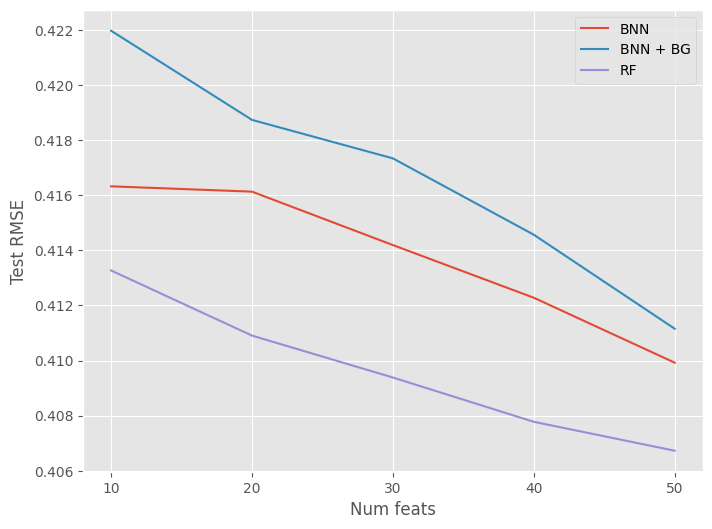

In [41]:
plt.rcParams["figure.figsize"] = (8,6)
for model in ["BNN", "BNN + BG", "RF"]:
    plt.plot(num_feats, bg_bnn_res_zero_out_1a[bg_bnn_res_zero_out_1a["model"] == model].groupby(["num_feats"]).mean()["test_rmse_score"].to_list(), label=model)
    plt.xticks(num_feats)
    plt.ylabel("Test RMSE")
    plt.xlabel("Num feats")
    plt.legend()

### Retrain Ranking

In [12]:
import warnings
warnings.filterwarnings("ignore")
retrain_hp_configs = {"epochs": 500, "num_cycles": 50, "batch_size": 32, "act_fn": "swish",
                      "beta": 0.36, "lr_0": 1e-3, "disc_lr_0": 0.5, "hidden_sizes": [500],
                      "temp": 1.0, "sigma": 1.0, "num_models": 2,
                      "mlp_config": {"epochs": 500, "lr_0": 1e-3, "hidden_sizes": [50],
                                     "act_fn": "swish"}}

save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/bortezomib"

VERSION = "1a"

num_feats = [10, 20, 30, 40, 50]
seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
curr_seeds = seeds
retrain_with_mlp(curr_seeds, X_selected, target, L, num_feats, VERSION, save_dir, dropout=False,
                 **retrain_hp_configs)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [42:26<00:00, 127.33s/it]

Done


In [14]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/bortezomib"
res_dfs = []
for seed in curr_seeds:
    df = pd.read_csv(f"{save_dir}/results/feat_retrain_comp_bnn_bg_rf_s_{seed}_ig_v{VERSION}.csv")
    res_dfs.append(df)

bg_bnn_res_retrain_1a = pd.concat(res_dfs, axis=0)
# bg_bnn_res_retrain_1a = bg_bnn_res_retrain_1a.drop_duplicates()
bg_bnn_res_retrain_1a.groupby(["model", "num_feats"]).mean().iloc[:,1:]

test_rmse_score
model    num_feats                 
BNN      10                0.579363
         20                0.717795
         30                0.715821
         40                0.690571
         50                0.675981
BNN + BG 10                0.570403
         20                0.769370
         30                0.693001
         40                0.678657
         50                0.670530
RF       10                0.475870
         20                0.655604
         30                0.693627
         40                0.657213
         50                0.675565

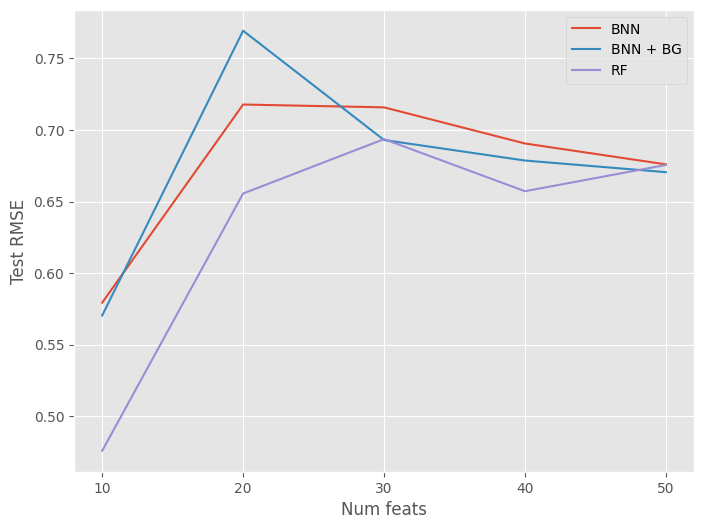

In [15]:
plt.rcParams["figure.figsize"] = (8,6)
for model in ["BNN", "BNN + BG", "RF"]:
    plt.plot(num_feats, bg_bnn_res_retrain_1a[bg_bnn_res_retrain_1a["model"] == model].groupby(["num_feats"]).mean()["test_rmse_score"].to_list(), label=model)
    plt.xticks(num_feats)
    plt.ylabel("Test RMSE")
    plt.xlabel("Num feats")
    plt.legend()